Import Module

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import imageio
import os
import shutil

Hyperparameter setting

In [11]:
epochs=1000
learning_rate=1e-3
#Batch Size -> Full Batch

#Number of points
num_GE=1000 #Governing Equation

#Terminal time
T=1

Loss functions

In [12]:
def relative_L2_error(predictions, targets):

  square_diff = (predictions - targets)**2
  relative_L2_error = torch.sqrt(torch.sum(square_diff))/torch.sqrt(torch.sum(targets**2))
  return relative_L2_error

mse_loss = nn.MSELoss()

Auxilary functions

In [13]:
def calculate_u(data):
    # Assuming data is a 1000x2 numpy array
    # First column is x values, second column is t values
    x = data[:, 0]
    t = data[:, 1]

    # Calculate u(x, t)
    u_values = np.sin(np.pi * x) * np.exp(np.sqrt(7) * t)
    
    return u_values

How input data is made

In [14]:
num_input=100
#points for GE
t_GE=T*torch.rand(size=(num_input,))
t_GE=t_GE.unsqueeze(1)

x_GE=2*torch.rand(size=(num_input,))-1
x_GE=x_GE.unsqueeze(1)

xt_GE=torch.hstack((x_GE, t_GE))

#points for IC
t_IC = torch.zeros((num_input,))
t_IC=t_IC.unsqueeze(1)

x_IC = 2 * torch.rand(size=(num_input, )) - 1
x_IC=x_IC.unsqueeze(1)

xt_IC = torch.hstack((x_IC, t_IC))

#points for BC

tensor_ones=torch.ones(50)
tensor_neg_ones=-1*torch.ones(50)

concat_tensor = torch.cat((tensor_ones, tensor_neg_ones), 0)

perm = torch.randperm(concat_tensor.size(0))
x_BC = concat_tensor[perm]

x_BC=x_BC
x_BC=x_BC.unsqueeze(1)

t_BC=T*torch.rand(size=(num_input,)) 
t_BC=t_BC.unsqueeze(1)

xt_BC = torch.hstack((x_BC, t_BC))

Input data plot

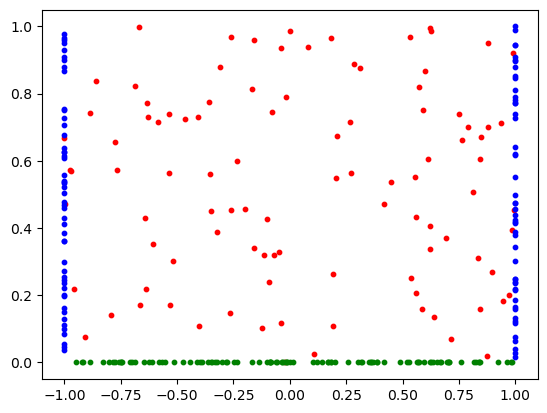

In [15]:
plt.scatter(*(xt_GE.numpy().T),
    s = 10, c = 'r', label='Red: Point for Govern Equation')
plt.scatter(*(xt_IC.numpy().T),
    s = 10, c = 'g', label='Green: Point for Initial Condition')
plt.scatter(*(xt_BC.numpy().T),
    s = 10, c = 'b', label='Blue: Point for Boundary Condition')

Define model architecture


In [16]:
class Model(nn.Module): #class child class(parent class)
  def __init__(self, hidden_dim=128):
    super(Model, self).__init__()
    self.hidden_dim=hidden_dim
    self.fc1=nn.Linear(in_features=2, out_features=self.hidden_dim)
    self.fc2=nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
    self.fc3=nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
    self.fc4=nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim)
    self.fc5=nn.Linear(in_features=self.hidden_dim, out_features=1)

  def forward(self, x):
    x=self.fc1(x)
    x=F.tanh(x)
    x=self.fc2(x)
    x=F.tanh(x)
    x=self.fc3(x)
    x=F.tanh(x)
    x=self.fc4(x)
    x=F.tanh(x)
    x=self.fc5(x)
    return x

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
# Instantiate the model
model = Model()

# Count the parameters
total_params = count_parameters(model)
print(f"Total number of parameters in the model: {total_params}")
print(model)


Total number of parameters in the model: 50049
Model(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)


Model to CUDA

In [24]:
model=Model().cuda()

Optimizer

In [25]:
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)

Train

In [26]:
for e in tqdm(range(1, epochs+1)):
    #Train
    model.train()
    ### 01. Data Generation (Collocation Points) ###

    #points for GE
    # Set the random seed for reproducibility


    t_GE=T*torch.rand(size=(num_GE,)).cuda() #(num_GE,)
    t_GE=t_GE.unsqueeze(1) #shape (num_GE,)->(num_GE, 1)

    x_GE = 2 * torch.rand(size=(num_GE,)).cuda() - 1
    x_GE = x_GE.unsqueeze(1)

    xt_GE = torch.hstack((x_GE, t_GE)).requires_grad_()

    #points for IC
    t_IC = torch.zeros((num_GE,)).cuda()
    t_IC=t_IC.unsqueeze(1)

    x_IC = 2 * torch.rand(size=(num_GE, )).cuda() - 1
    x_IC=x_IC.unsqueeze(1) #shape (num_GE,)->(num_GE, 1)

    xt_IC = torch.hstack((x_IC, t_IC))

    #points for BC

    tensor_ones=torch.ones(500)
    tensor_neg_ones=-1*torch.ones(500)

    concat_tensor = torch.cat((tensor_ones, tensor_neg_ones), 0)

    perm = torch.randperm(concat_tensor.size(0))
    x_BC = concat_tensor[perm]

    x_BC=x_BC.cuda()
    x_BC=x_BC.unsqueeze(1)

    t_BC=T*torch.rand(size=(num_GE,)).cuda() #(num_GE,)
    t_BC=t_BC.unsqueeze(1)

    xt_BC = torch.hstack((x_BC, t_BC))


    ## 02. Update Parameters
    optimizer.zero_grad()

    #Loss_GE
    t_GE.requires_grad=True
    u_pred_GE=model(xt_GE)

    ut_GE=torch.autograd.grad(u_pred_GE, xt_GE, create_graph=True, grad_outputs=torch.ones_like(u_pred_GE))[0][:,1]

    ux_GE=torch.autograd.grad(u_pred_GE, xt_GE, create_graph=True, grad_outputs=torch.ones_like(u_pred_GE))[0][:,0].unsqueeze(1)
    uxx_GE=torch.autograd.grad(ux_GE, xt_GE, create_graph=True, grad_outputs=torch.ones_like(u_pred_GE))[0][:,0]

    Loss_GE=((ut_GE-uxx_GE-((torch.pi)**2-np.sqrt(7))*(torch.exp(-np.sqrt(7)*t_GE.squeeze()))*torch.sin(torch.pi*x_GE.squeeze()))**2).mean()


    #Loss_IC
    Loss_IC=((model(xt_IC).squeeze()-torch.sin(torch.pi*x_IC.squeeze()))**2).mean()

    #Loss_BC
    Loss_BC=((model(xt_BC).squeeze())**2).mean()



    #Loss_Total -> Update
    Loss_Total=Loss_GE+Loss_IC+Loss_BC
    Loss_Total.backward()
    optimizer.step() #Backpropagation->Update Parameters

    #Print()
    if e%100==0:
        print('{}th Loss_GE {:.4f}'.format(e, Loss_GE))
        print('{}th Loss_BC {:.4f}'.format(e, Loss_BC))
        print('{}th Loss_IC {:.4f}'.format(e, Loss_IC))
        print("")

  0%|          | 0/1000 [00:00<?, ?it/s]

100th Loss_GE 0.0376
100th Loss_BC 0.0305
100th Loss_IC 0.0077

200th Loss_GE 0.0088
200th Loss_BC 0.0075
200th Loss_IC 0.0026

300th Loss_GE 0.0052
300th Loss_BC 0.0020
300th Loss_IC 0.0008

400th Loss_GE 0.0020
400th Loss_BC 0.0006
400th Loss_IC 0.0005

500th Loss_GE 0.0011
500th Loss_BC 0.0004
500th Loss_IC 0.0006

600th Loss_GE 0.0013
600th Loss_BC 0.0002
600th Loss_IC 0.0002

700th Loss_GE 0.0007
700th Loss_BC 0.0000
700th Loss_IC 0.0001

800th Loss_GE 0.0006
800th Loss_BC 0.0001
800th Loss_IC 0.0001

900th Loss_GE 0.0008
900th Loss_BC 0.0001
900th Loss_IC 0.0000

1000th Loss_GE 0.0004
1000th Loss_BC 0.0001
1000th Loss_IC 0.0002



Generating ground truth data of 1D-Heat Equation

$$ u(x, t) = \sin\pi (x) \cdot e^{\sqrt{7}t} $$



In [36]:
def generate_data_and_calculate_u():
    # Generating x values from -1 to 1 in steps of 0.05
    x_values = np.arange(-1, 1.01, 0.01)

    # Generating t values from 0 to 1 in steps of 0.1
    t_values = np.arange(0, 1.01, 0.01)

    # Preparing a container for the results
    u_values_over_time = []

    # Calculating u(x, t) for each time step
    for t in t_values:
        u_values = np.sin(np.pi * x_values) * np.exp(-np.sqrt(7) * t)
        u_values_over_time.append(u_values)

    return np.array(u_values_over_time)

Function for creating animation

In [28]:
def create_animation(u_data, filename='1D_Heat_GT_animation.gif', color_range=1):
    # Create a temporary directory to store images
    temp_dir = 'temp_images'
    os.makedirs(temp_dir, exist_ok=True)

    # Generate images for each time step
    for i, u_values in enumerate(u_data):
        plt.figure(figsize=(8, 2))
        plt.imshow([u_values], aspect='auto', cmap='seismic', vmin=-color_range, vmax=color_range)
        plt.colorbar(label='Temperature')
        plt.title(f'Time: {i*0.01:.2f}')
        plt.xticks(ticks=np.linspace(0, len(u_values)-1, num=5), labels=np.linspace(-1, 1, num=5))
        plt.yticks([])
        plt.xlabel('x')
        
        image_path = os.path.join(temp_dir, f'{i}.png')
        plt.savefig(image_path)
        plt.close()

    # Create GIF
    with imageio.get_writer(filename, mode='I', duration=0.2) as writer:
        for i in range(len(u_data)):
            image_path = os.path.join(temp_dir, f'{i}.png')
            image = imageio.imread(image_path)
            writer.append_data(image)

    # Cleanup: remove temporary images
    shutil.rmtree(temp_dir)


Generate ground truth data

In [37]:
u_data = generate_data_and_calculate_u()

Create animation of ground truth data

In [ ]:
# Create and save the animation
create_animation(u_data)

Generate input data for prediction

In [38]:
x_values = np.arange(-1, 1.01, 0.01)
t_values = np.arange(0, 1.01, 0.01)
X, T = np.meshgrid(x_values, t_values)
input_data = np.vstack([X.ravel(), T.ravel()]).T

Prediction

In [39]:
# Convert to PyTorch tensor
input_tensor = torch.tensor(input_data, dtype=torch.float32).cuda()

# Pass the data through the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    predictions = model(input_tensor)

# Reshape the output
u_pred = predictions.cpu().numpy().reshape(T.shape)

Create animation of prediction data

In [77]:
create_animation(u_pred, '1D_Heat_pred_animation.gif', color_range=1)

C:\Users\Jiseok\AppData\Local\Temp\ipykernel_21428\1540000255.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Create animation of ground truth - prediction

In [40]:
# Create and save the animation
create_animation(u_data-u_pred, '1D_Heat_diff_animation.gif', color_range=0.1)

C:\Users\Jiseok\AppData\Local\Temp\ipykernel_21224\1540000255.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


Calculate MSE

In [41]:
# Calculate the squared differences
squared_differences = np.square(u_pred - u_data)

# Calculate the Mean Squared Error
mse = np.mean(squared_differences)
print(mse)

0.00018617813267126572


Initial condition plot

Text(0.5, 0, 'x')

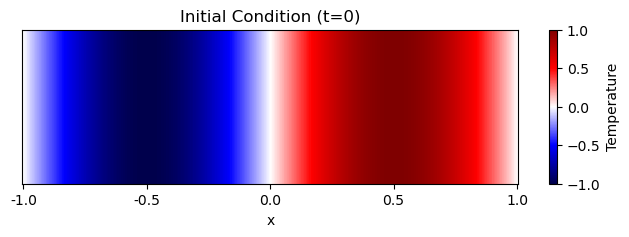

In [81]:
plt.figure(figsize=(8, 2))
plt.imshow([u_data[0]], aspect='auto', cmap='seismic', vmin=-1, vmax=1)
plt.colorbar(label='Temperature')
plt.title('Initial Condition (t=0)')
plt.xticks(ticks=np.linspace(0, len(u_data[0])-1, num=5), labels=np.linspace(-1, 1, num=5))
plt.yticks([])
plt.xlabel('x')
